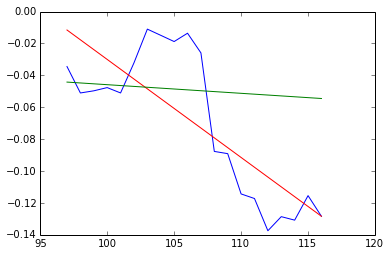

In [1]:
import pandas as pd
import numpy as np
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML
from pykalman import UnscentedKalmanFilter
import pylab as pl

%matplotlib inline
pd.set_option('display.width',500)

bars = pd.DataFrame(pd.read_csv('bars.csv'))
# bars = bars[:10]
# display(HTML(bars.to_html()))
bars = bars.reset_index()
daywindow = 500

# x = np.linspace(daywindow-19,daywindow,20) 
# print x

def tran_func(x,w):
    return x + np.sin(w)

def show_args(Code= 85):
    
#     print Code
    daywindow = Code
    barsbench = bars['bench'][daywindow-20:daywindow]

    x = np.linspace(daywindow-19,daywindow,20) 
    
    barsma3pct = bars['ma3closePct'][daywindow-20:daywindow]
    
#     barsbench = bars['bench'][1:daywindow]

#     x = np.linspace(1,daywindow,daywindow-1) 
#     print len(x),len(barsbench)
    # print x
    # print barsbench
    # print len(barsbench)
    # print barsbench.values
    paramval = np.polyfit(x,barsbench.values,1)
    paramval_ma3 = np.polyfit(x,barsma3pct.values,1)
#     paramval2 = np.polyfit(x,barsbench.values,2)
#     paramval3 = np.polyfit(x,barsbench.values,3)
    
#     initial_state_mean_in = bars['bench'][1]
#     observations = bars['bench'][daywindow-20:daywindow].values


#     ukf = UnscentedKalmanFilter(tran_func, lambda x, v: x + np.sin(v), transition_covariance=0.1,initial_state_mean=initial_state_mean_in)
#     (filtered_state_means, filtered_state_covariances) = ukf.filter(observations)
#     (smoothed_state_means, smoothed_state_covariances) = ukf.smooth(observations)
#     predictdf = pd.DataFrame({'predict':filtered_state_means[:,0],'smooth':smoothed_state_means[:,0]})

#     predictdf['predict']
#     predictdf['smooth']
    
    pl.clf()
    pl.plot(x,barsbench)
    pl.plot(x,np.polyval(paramval,x),'r-')
    pl.plot(x,np.polyval(paramval_ma3,x),'g-')
#     pl.plot(x,predictdf['smooth'],'g-')
#     pl.plot(x,np.polyval(paramval2,x),'g-')
#     pl.plot(x,np.polyval(paramval3,x),'c-')
    pl.show()
#     print paramval,paramval2,paramval3
#     print abs(paramval[0]-paramval2[0]),abs(paramval[0]-paramval3[0])

i = interact(show_args,Code=(1,daywindow-1))



In [127]:
import pandas.io.data as web
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.widgets as wd
import sklearn.hmm as lrn


def stkHMM(lrndata, n_components):
    model = lrn.GaussianHMM(n_components, covariance_type="tied", n_iter=20)
    model.fit([lrndata])

    hidden_states = model.predict(lrndata)
    return [model, hidden_states]


def plot_data(stkname, fig, topplt, botplt, mlrnplt, sidplt):
    #Get data from yahoo
    #Calculate olling mean, mean and current value of stock
    #Also calculate length of data
    print 'stkname:',stkname
    startdate = dt.date(2014, 1, 1)
    stkdata = web.DataReader(stkname, 'yahoo', startdate)
    stklen = len(stkdata.index)
    enddate = dt.datetime.date(stkdata.index[stklen-1])
    stkrolmean = pd.ewma(stkdata['Close'], 60)
    stkmean = stkdata['Close'].mean(1).round(2)
    stkcur = stkdata['Close'][stklen-1]
    stkmax = stkdata['Close'].max(1)
    stkmin = stkdata['Close'].min(1)
    stkmchnlrndata = np.column_stack([stkdata['Close'], stkdata['Volume']])
    ncomponents = 5
    lrnmodel, hiddenstates = stkHMM(stkmchnlrndata, ncomponents)
    nxtstateidx = lrnmodel.transmat_[hiddenstates[len(hiddenstates)-1], :]
    nxtstateprob = np.amax(nxtstateidx)
    nxtstate = np.argmax(nxtstateidx)

    #Decoration for annotation of latest trading value
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # display(HTML(hiddenstates.to_html()))
    # print stkdata.head()
    print hiddenstates,len(hiddenstates)
    # print stkdata,len(stkdata)
    print nxtstate, nxtstateidx,nxtstateprob

    print "means and vars of each hidden state"
    for i in xrange(ncomponents):
        print "%dth hidden state" % i
        print 'mean = ',lrnmodel.means_[i]
        print 'var = ', np.diag(lrnmodel.covars_[i])
        print ""
    #Clear all axes
    # topplt.cla()
    # botplt.cla()
    # mlrnplt.cla()
    # sidplt.cla()

    # #Top plot: Closing data, mean and rolling mean
    # topplt.plot(stkdata.index, stkdata['Close'], stkdata.index,
    #             stkmean*np.ones(stklen), stkdata.index, stkrolmean,)
    # topplt.set_title('{} Stock Price from {} to {}'.format(stkname,
    #                  startdate, enddate))
    # topplt.grid(True)
    # topymin, topymax = topplt.get_ylim()
    # topplt.text(0.05, 0.95, 'Trading price on {}: ${}'.format(enddate,
    #             stkcur), transform=topplt.transAxes, fontsize=14,
    #             verticalalignment='top', bbox=props)
    # topplt.fill_between(stkdata.index, stkdata['Close'],
    #                     (topymin+0.01)*np.ones(stklen), alpha=0.5)
    # topplt.legend(('Close', 'Mean', 'EWMA'), 'lower right', shadow=True,
    #               fancybox=True, fontsize=8)

    # #Bottom plot: Bar Graph, trading volume
    # botplt.bar(stkdata.index, stkdata['Volume'])
    # botplt.set_title('{} Trading Volume'.format(stkname))

    # #Machine Learn plot
    # for i in xrange(ncomponents):
    #     idx = (hiddenstates == i)
    #     mlrnplt.plot_date(stkdata.index[idx], stkdata['Close'][idx], 'o',
    #                       label='Hidden state: {}'.format(i))
    # mlrnplt.legend(loc='best', fancybox=True, shadow=True, fontsize=8)
    # mlrnplt.grid(True)
    # mlrnplt.text(0.99, 0.1,
    #              'Next State: {} with {:.2f}% probability'
    #              .format(nxtstate, nxtstateprob*100),
    #              transform=mlrnplt.transAxes, fontsize=10,
    #              horizontalalignment='right', verticalalignment='center',
    #              bbox=props)
    # mlrnplt.set_title('Hidden Markov Model States')

    # #Side plot: histogram of 'high-low'
    # sidplt.hist(stkdata['High']-stkdata['Low'], bins=50, normed=True)
    # sidplt.set_title('Stock Value Variation')
    # sidplt.grid(True)
    # sidplt.text(0.70, 0.50, '{} Trading Value Stats\nMean:${}\nHighest:${}'
    #             '\nLowest:${}'.format(stkname, stkmean, stkmax, stkmin),
    #             transform=sidplt.transAxes, fontsize=12,
    #             verticalalignment='top', horizontalalignment='center',
    #             bbox=props)

    # #Remove xticklabels on top plot
    # plt.setp(topplt.get_xticklabels(), visible=False)
    # plt.setp(botplt.get_xticklabels(), visible=False)
    # plt.tight_layout()
    return fig


def setup():
    stklst = sorted(('ABB', 'AMZN', 'GE', 'GOOG', 'MSFT', 'YHOO', 'EBAY'))

    #Setup figure
    #Top, Bottom, Side with top and bottom plot sharing x axis
    fig = plt.figure()
    # top = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    # bot = plt.subplot2grid((3, 3), (1, 0), colspan=2, sharex=top)
    # mlrn = plt.subplot2grid((3, 3), (2, 0), colspan=2, sharex=top)
    # sid = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

    fig = plot_data(stklst[0], fig, top, bot, mlrn, sid)

    #Setup for radio bottoms
    # axcolor = 'lightgoldenrodyellow'
    # ylen = len(stklst)/50.0
    # prop_radio = plt.axes([0.95, 1-ylen, 0.048, ylen], axisbg=axcolor)
    # radio = wd.RadioButtons(prop_radio, stklst)

    return [fig, top, bot, sid, mlrn, radio]

if __name__ == "__main__":
    fig, top, bot, sid, mlrn, radio = setup()

    #Setup multicursor between top and bottom plot
    multi = wd.MultiCursor(fig.canvas, (top, bot, mlrn), color='r', lw=2)

    def stocksel(label):
        plot_data(label, fig, top, bot, mlrn, sid)

    radio.on_clicked(stocksel)

    #Show plot
    # plt.show()


stkname: ABB
[1 3 1 3 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 4 2 4 3 1 4 4 3 1 1
 1 3 0 0 0 0 3 1 1 1 1 3 0 0 0 0 0 0 3 1 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 4 4 2 4 4 4 2 1 1 1 1 1 3 3 1 3 3 2 1 3 0 3 1 4 3 0 0 0 0 3
 1 1 3 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 3 0 0 3 1 1 1 2 4 1 1 1 1 1 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 1 3 0 0 0 3 1 1 3 0 0 3 1 1 3 3 1 1 3 3 1 4 3 1
 3 3 1 1 1 1 4 4 2 4 1 1 1 1 1 1 1 1 4 3 0 0 0 0 0 0 0 3 1 3 0 0 0 3 1 3 0
 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 4 2 4 3 0 0 0 0 0 0 0 3 1 1 1 1 1
 1 1 2 4 4 2 1 1 1 1 1 1 1 1 1 4 1 1 2 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 1 1 4 1 1 3 0 0 0 0 0 0] 315
0 [  5.39648818e-01   9.59787048e-02   1.10568973e-02   3.53069101e-01
   2.46478505e-04] 0.539648817989
means and vars of each hidden state
0th hidden state
mean =  [  2.30592028e+01   1.25984352e+06]
var =  [  3.46414906e+00   1.81793213e+11]

1th hidden state
mean =  [  2.27213432e+01   2.15982686e+06]
var =  [  3.46414906e+00   1.8179321

In [137]:
import pandas as pd
import numpy as np
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML
from pykalman import UnscentedKalmanFilter
import pylab as pl
import pandas
from statsmodels import api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, Imputer
%matplotlib inline
pd.set_option('display.width',500)

bars = pd.DataFrame(pd.read_csv('bars.csv'))
# bars = bars[:10]
# display(HTML(bars.to_html()))
bars = bars.reset_index()


def top_and_bottom(datapanel):
    lag = 10
    prices = datapanel['Close']
    data = prices.values.T
    xs = []
    ys = []
    
#     data = [data]
#     print data
    for row in data:
        x, y = sm.tsa.lagmat(np.diff(row), maxlag=lag,
                             original='sep',trim='both')
        xs.append(x)
        ys.append(y.ravel())
    xs = np.vstack(xs)
    ys = (np.vstack(ys).ravel() > 0).astype('int')
    imp = Imputer()
    pre = StandardScaler()
    model = GaussianNB()
    xs = imp.fit_transform(xs)
    xs = pre.fit_transform(xs)
    model.fit(xs, ys)
    design = np.diff(data)[:, -lag:]
    design = imp.transform(design)
    design = pre.transform(design)
    ps = model.predict_proba(design)[:,1]
    pred = pandas.DataFrame(ps.reshape(1, -1),
                            index=prices.index[-1:],
                            columns=prices.columns)
    #Dataframe 1 column
    last_returns = pred[-1:]
    last_date = pred.index[-1]
    sorted_returns = last_returns.T.sort(columns=last_date, ascending=0)
    return sorted_returns

retdata = top_and_bottom(bars)
print retdata


IndexError: list assignment index out of range

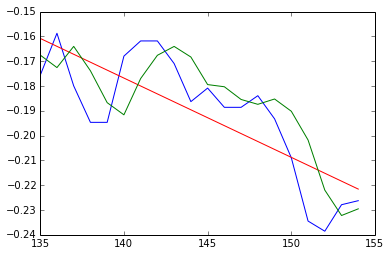

In [33]:
from numpy import diag, eye, zeros, pi, exp, dot, sum, tile, linalg, array
from numpy import log as logg
from numpy.linalg import inv, det
from numpy.random import randn
import numpy as np
import random
import pandas as pd
import numpy as np
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML
from pykalman import UnscentedKalmanFilter
import pylab as pl
%matplotlib inline


# pd.set_option('display.width',500)
# global bars
bars = pd.DataFrame(pd.read_csv('bars.csv'))
# bars = bars[:10]
# display(HTML(bars.to_html()))
bars = bars.reset_index()
bars['kpredict'] = 0.0


def kf_predict(X, P, A, Q, B, U):
    X = dot(A, X) + dot(B, U)
    P = dot(A, dot(P, A.T)) + Q
    return(X,P)


def kf_update(X, P, Y, H, R):
    IM = dot(H, X)
    IS = R + dot(H, dot(P, H.T))
    K = dot(P, dot(H.T, inv(IS)))
    X = X + dot(K, (Y-IM))
    P = P - dot(K, dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)
    
def gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - tile(M, X.shape[1])
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * logg(2 * pi) + 0.5 * logg(det(S))
        P = exp(-E)
    elif X.shape[1] == 1:
        DX = tile(X, M.shape[1])- M
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * logg(2 * pi) + 0.5 * logg(det(S))
        P = exp(-E)
    else:
        DX = X-M
        E = 0.5 * dot(DX.T, dot(inv(S), DX))
        E = E + 0.5 * M.shape[0] * logg(2 * pi) + 0.5 * logg(det(S))
        P = exp(-E)
    return (P[0],E[0])



def handle_data(data,X,P,A,Q,B,U,Y,H,R):
   
    (X, P) = kf_predict(X, P, A, Q, B, U)
   
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)  
   
    Y = array([[data],[data]])
#     Y = array([[data]])
      
    observed = Y[0][0]    
    filtered = X[0][0]
    bars['kpredict'][day] = filtered
#     print observed,filtered
#     print bars['kpredict'][day]
    return X,P,K,IM,IS,LH,Y

   
if __name__ == "__main__":
    total_securites = 2
    # Select securites
    # securites = [sid(26578), sid(24)]
    initX = np.zeros((total_securites*2,1))
    initP = np.diag(np.zeros(total_securites*2))
    initA = array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0,0]])    
    initQ = eye(X.shape[0])
    initB = eye(X.shape[0])
    initU = zeros((X.shape[0],1))
    initY = array([[0], [0]])
    initH = array([[1, 0, 0, 0], [0, 1, 0, 0]])
    initR = eye(Y.shape[0])
    
    for day in range(len(bars)):
        price = bars['bench'][day]
        if day == 1:
            X,P,K,IM,IS,LH,Y = handle_data(price,initX,initP,initA,initQ,initB,initU,initY,initH,initR)   
        else:
            X,P,K,IM,IS,LH,Y = handle_data(price,X,P,initA,initQ,initB,initU,Y,initH,initR)   
            
daywindow = 550    
def show_args(Code= 85):
    
#     print Code
    daywindow = Code
    barsbench = bars['bench'][daywindow-20:daywindow]
    barskpredict = bars['kpredict'][daywindow-20:daywindow]

    x = np.linspace(daywindow-19,daywindow,20) 
    
    
    paramval = np.polyfit(x,barsbench.values,1)
    
    pl.clf()
    pl.plot(x,barsbench)
    pl.plot(x,np.polyval(paramval,x),'r-')
    pl.plot(x,barskpredict,'g-')

    pl.show()

i = interact(show_args,Code=(1,daywindow-1))

        

In [126]:
print  2.30598055e+01, 1.26042964e+06,3.46428901e+00

23.0598055 1260429.64 3.46428901
